# DeepInsight: Transforming Non-image data to Images for CNN Architectures
***
This notebook introduces an interesting and useful preprocessing method for non-image data to be applicable in Convolutional Neural Networks (CNN) architectures. It was published in **_Scientific Reports_** of **Nature** in 2019, and I occasionally discovered it while searching for related deep learning materials to Mechanisms of Action.

The idea is very straightforward: Instead of doing feature extraction and selection for collected samples (<em>N</em> samples x <em>d</em> features), we would like to find a way of **arranging similar or correlated features into the neighboring regions of a 2-dimensional feature map (<em>d</em> features x <em>N</em> samples)** to ease the learning of their complex relationships and interactions. With this general approach, in theory we could transform any kind of non-image data into feature map images as a friendly representation of samples to CNNs, which provide several unique benefits compared with other neural network architectures, such as automated feature extraction from raw features and memory-footprint reduction by effective weight-sharing.

The following diagram outlines the key steps. First of all, a non-linear dimensionality reduction technique, like t-SNE or Kernel PCA, is applied to transform raw features into a 2D embeddings feature space. Secondly, the convex hull algorithm is used to find the smallest rectangle containing all features and a rotation is performed to align the feature map frame into a horizontal or vertical form. Finally, the raw feature values are mapped into the pixel coordinate locations of the feature map image. Note that the resolution of feature map image affects the ratio of feature overlaps (the features mapped to the same location are averaged), which is a trade-off between the level of lossy compression and computing resource requirements (e.g., host/GPU memory, storage).

![DeepInsight Architecture](https://storage.googleapis.com/kaggle-markpeng/MoA/deepinsight_architecture.png)
<div align="center">Source: <a href="https://www.nature.com/articles/s41598-019-47765-6" target="_blank">https://www.nature.com/articles/s41598-019-47765-6</a></div>

<br/>

The authors had tested the method with a parallel CNN architecture on different kinds of datasets, including <a href="https://cancergenome.nih.gov" target="_blank">RNA-seq data</a> (gene expressions), <a href="https://jundongl.github.io/scikit-feature/OLD/datasets_old.html" target="_blank">Text data</a> and <a href="https://catalog.ldc.upenn.edu/LDC93S1" target="_blank">Speech data</a>, and showed positive results. Their implementation was in Matlab, but in the <a href="https://github.com/alok-ai-lab/DeepInsight" target="_blank">public Github repository</a> they shared it also includes a Python version for the transformation part.

In this notebook, the outlook of feature maps for all MoA features is demonstrated by t-SNE. You can also separate the transformation process for different groups of features (e.g., gene expressions, cell viabilities) There is a discrepancy between the Matlab version (aligned with the paper) and Python version regarding feature normalization, therefore some minor adjustments have been done here. The effect of perplexity is also being studied.

***
This kind of transformation should open up the gates of transfer learning (ResNeSts, EfficientNets, DenseNets) and creative data augmentation techniques (CutMix, Mixup, etc.) for this small gene expression dataset. Also a great source of model diversity for the ensembles!

Please upvote or cite this notebook if you like it, thanks!

***

**Next Reading:**

<a href="https://www.kaggle.com/markpeng/deepinsight-efficientnet-b3-noisystudent" target="_blank">DeepInsight EfficientNet-B3 Infernece Notebook</a>

***

**Reference:**

Sharma, Alok, Edwin Vans, D. Shigemizu, Keith A. Boroevich and T. Tsunoda (2019). "_DeepInsight: A methodology to transform a non-image data to an image for convolution neural network architecture_," Scientific Reports, nature.com.


In [1]:
kernel_mode = True

import sys
if kernel_mode:
    sys.path.insert(0, "../input/iterative-stratification")

import os
import numpy as np
import pandas as pd
import time
import random
import math

import matplotlib
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.manifold import TSNE

import seaborn as sns
sns.set(style="darkgrid")

import gc
gc.enable()

rand_seed = 1120

In [2]:
dataset_folder = "../input/lish-moa"

# Load MoA Data

In [3]:
train_features = pd.read_csv(
    f"{dataset_folder}/train_features.csv", engine='c')
train_labels = pd.read_csv(
    f"{dataset_folder}/train_targets_scored.csv", engine='c')

train_extra_labels = pd.read_csv(
    f"{dataset_folder}/train_targets_nonscored.csv", engine='c')

test_features = pd.read_csv(
    f"{dataset_folder}/test_features.csv", engine='c')

In [4]:
train_features.shape, train_labels.shape, train_extra_labels.shape

((23814, 876), (23814, 207), (23814, 403))

In [5]:
test_features.shape

(3982, 876)

In [6]:
category_features = ["cp_type", "cp_dose"]
numeric_features = [c for c in train_features.columns if c != "sig_id" and c not in category_features]
all_features = category_features + numeric_features
gene_experssion_features = [c for c in numeric_features if c.startswith("g-")]
cell_viability_features = [c for c in numeric_features if c.startswith("c-")]
len(numeric_features), len(gene_experssion_features), len(cell_viability_features)

(873, 772, 100)

In [7]:
train_classes = [c for c in train_labels.columns if c != "sig_id"]
train_extra_classes = [c for c in train_extra_labels.columns if c != "sig_id"]
len(train_classes), len(train_extra_classes)

(206, 402)

# Feature Encoding
As we only have three metadata features, a quick manual encoding process is done. All features are normalized into the value range of [0, 1].

In [8]:
for df in [train_features, test_features]:
    df['cp_type'] = df['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
    df['cp_dose'] = df['cp_dose'].map({'D1': 0, 'D2': 1})
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 0.5, 72: 1})

In [9]:
cm = sns.light_palette("seagreen", as_cmap=True)
train_features["cp_type"].value_counts(
    dropna=False).to_frame().style.background_gradient(cmap=cm)

,cp_type
1,21948
0,1866


In [10]:
cm = sns.light_palette("blue", as_cmap=True)
train_features["cp_dose"].value_counts(
    dropna=False).to_frame().style.background_gradient(cmap=cm)

,cp_dose
0,12147
1,11667


In [11]:
cm = sns.light_palette("red", as_cmap=True)
train_features["cp_time"].value_counts(
    dropna=False).to_frame().style.background_gradient(cmap=cm)

,cp_time
0.5,8250
1.0,7792
0.0,7772


# Create Stratified Multi-label K-folds

Here only the first fold is used as training and validate sets for demonstration. The generation of feature map only relies on the training set to ensure the generalization of preprocessed data and further trained models.

In [12]:
kfolds = 10
skf = MultilabelStratifiedKFold(n_splits=kfolds,
                                shuffle=True,
                                random_state=rand_seed)

label_counts = np.sum(train_labels.drop("sig_id", axis=1), axis=0)
y_labels = label_counts.index.tolist()

In [13]:
train_index, val_index = list(skf.split(train_features,
                                        train_labels[y_labels]))[0]

In [14]:
train_all_features = train_features.loc[train_index,
                                        all_features].copy().reset_index(
                                            drop=True).values
valid_all_features = train_features.loc[val_index,
                                        all_features].copy().reset_index(
                                            drop=True).values
test_all_features = train_features[all_features].copy().reset_index(
    drop=True).values
train_all_features.shape, valid_all_features.shape, test_all_features.shape

((21432, 875), (2382, 875), (23814, 875))

# DeepInsight Transform - t-SNE 2D Embeddings
Based on https://github.com/alok-ai-lab/DeepInsight, but with some corrections to the norm-2 normalization.

Most of the credits should be given to the original authors!

## Implementation

Checkout <a href="https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-47765-6/MediaObjects/41598_2019_47765_MOESM1_ESM.pdf" target="_blank">DeepInsight paper supplementary information</a> for more details.

In [15]:
# Modified from DeepInsight Transform
# https://github.com/alok-ai-lab/DeepInsight/blob/master/pyDeepInsight/image_transformer.py


class LogScaler:
    """Log normalize and scale data

    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    
    Note: The dimensions of input matrix is (N samples, d features)
    """
    def __init__(self):
        self._min0 = None
        self._max = None

    """
    Use this as a preprocessing step in inference mode.
    """
    def fit(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

    """
    For training set only.
    """
    def fit_transform(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

    """
    For validation and test set only.
    """
    def transform(self, X, y=None):
        # Adjust min. of each feature of X by _min0
        for i in range(X.shape[1]):
            X[:, i] = X[:, i].clip(min=self._min0[i], max=None)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

In [16]:
# Modified from DeepInsight Transform
# https://github.com/alok-ai-lab/DeepInsight/blob/master/pyDeepInsight/image_transformer.py

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect


class DeepInsightTransformer:
    """Transform features to an image matrix using dimensionality reduction

    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix

    """
    def __init__(self,
                 feature_extractor='tsne',
                 perplexity=30,
                 pixels=100,
                 random_state=None,
                 n_jobs=None):
        """Generate an ImageTransformer instance

        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne_exact'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='exact',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'tsne'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='barnes_hut',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2, random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(n_components=2,
                               kernel='rbf',
                               random_state=self.random_state,
                               n_jobs=self.n_jobs)
            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)

        # The resolution of transformed image
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y=None, plot=False):
        """Train the image transformer from the training set (X)

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle

        Returns:
            self: object
        """
        # Transpose to get (n_features, n_samples)
        X = X.T

        # Perform dimensionality reduction
        x_new = self._fe.fit_transform(X)

        # Get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]

        # Determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)

        # Rotate the matrix
        # Save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T

        # Determine feature coordinates based on pixel dimension
        self._calculate_coords()

        # plot rotation diagram if requested
        if plot is True:
            # Create subplots
            fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
            ax[0, 0].scatter(x_new[:, 0],
                             x_new[:, 1],
                             cmap=plt.cm.get_cmap("jet", 10),
                             marker="x",
                             alpha=1.0)
            ax[0, 0].fill(x_new[chvertices, 0],
                          x_new[chvertices, 1],
                          edgecolor='r',
                          fill=False)
            ax[0, 0].fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        """The image matrix dimensions

        Returns:
            tuple: the image matrix dimensions (height, width)

        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension

        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix

        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(self._xrot[:, 0],
                                bins=np.linspace(min(self._xrot[:, 0]),
                                                 max(self._xrot[:, 0]),
                                                 self._pixels[0])) - 1
        ax1_coord = np.digitize(self._xrot[:, 1],
                                bins=np.linspace(min(self._xrot[:, 1]),
                                                 max(self._xrot[:, 1]),
                                                 self._pixels[1])) - 1
        self._coords = np.stack((ax0_coord, ax1_coord))

    def transform(self, X, empty_value=0):
        """Transform the input matrix into image matrices

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """

        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        img_coords = pd.DataFrame(np.vstack(
            (self._coords, X.clip(0, 1))).T).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        return img_matrices

    def fit_transform(self, X, empty_value=0):
        """Train the image transformer from the training set (X) and return
        the transformed data.

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform(X, empty_value=empty_value)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel

        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        coord_cnt = (
            pd.DataFrame(self._coords.T).assign(count=1).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).count())
        fdmat[coord_cnt[0].astype(int),
              coord_cnt[1].astype(int)] = coord_cnt['count']
        return fdmat

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.

        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.

        Args:
            hull_points : an nx2 matrix of hull coordinates

        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2.

        # Calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)

        # Find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            np.cos(angles - pi2),
            np.cos(angles + pi2),
            np.cos(angles)
        ]).T
        rotations = rotations.reshape((-1, 2, 2))

        # Apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)

        # Find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)

        # Find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)

        # Return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]

        # Generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

## Norm-2 Normalization
Again, raw features are normalized into the value range of [0, 1].

In [17]:
all_scaler = LogScaler()
train_all_features = all_scaler.fit_transform(train_all_features)
valid_all_features = all_scaler.transform(valid_all_features)
test_all_features = all_scaler.transform(test_all_features)

## t-SNE Transformation

In the nice post of <a href="https://distill.pub/2016/misread-tsne/" target="_blank">"<em>How to Use t-SNE Effectively</em>"</a>, we have seen that the choice of perplexity (a guess about the number of close neighbors each point has) in the t-SNE algorithm is tricky and its visual output in the embeddings feature space could be misleading. Here several values of perplexity are being set to see the difference (typical values are between 5 and 50). The similarity of features are estimated by cosine distance.

In [18]:
def plot_embed_2D(X, title=None):
    sns.set(style="darkgrid")

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
    ax[0, 0].scatter(X[:, 0],
                     X[:, 1],
                     cmap=plt.cm.get_cmap("jet", 10),
                     marker="x",
                     alpha=1.0)
    plt.gca().set_aspect('equal', adjustable='box')

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()


def tsne_transform(data, perplexity=30, plot=True):
    # Transpose to get (n_features, n_samples)
    data = data.T

    tsne = TSNE(n_components=2,
                metric='cosine',
                perplexity=perplexity,
                n_iter=1000,
                method='exact',
                random_state=rand_seed,
                n_jobs=-1)
    # Transpose to get (n_features, n_samples)
    transformed = tsne.fit_transform(data)

    if plot:
        plot_embed_2D(
            transformed,
            f"All Feature Location Matrix of Training Set (Perplexity: {perplexity})"
        )
    return transformed

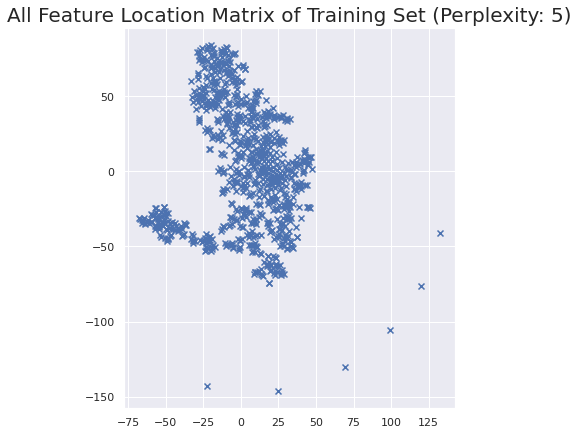

In [19]:
train_all_tsne = tsne_transform(train_all_features, perplexity=5)

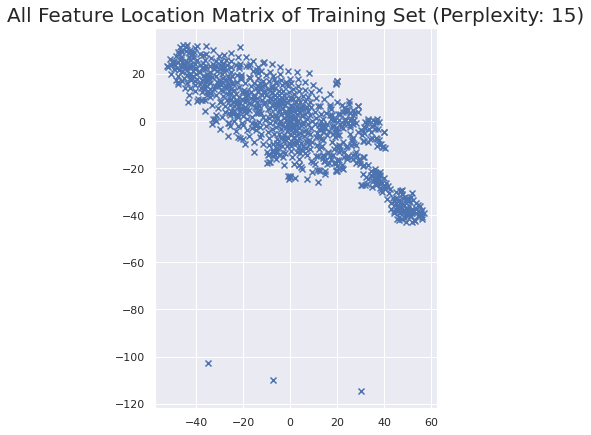

In [20]:
train_all_tsne = tsne_transform(train_all_features, perplexity=15)

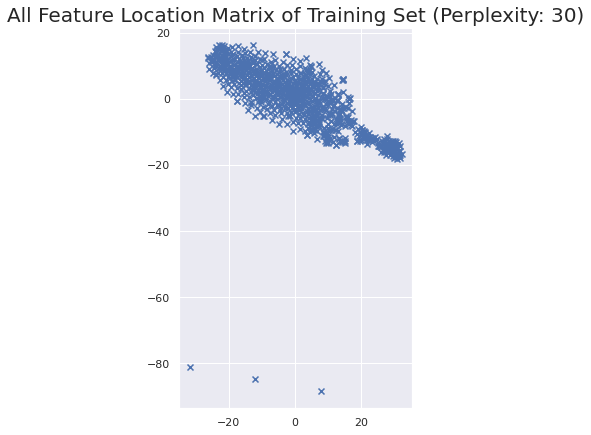

In [21]:
train_all_tsne = tsne_transform(train_all_features, perplexity=30)

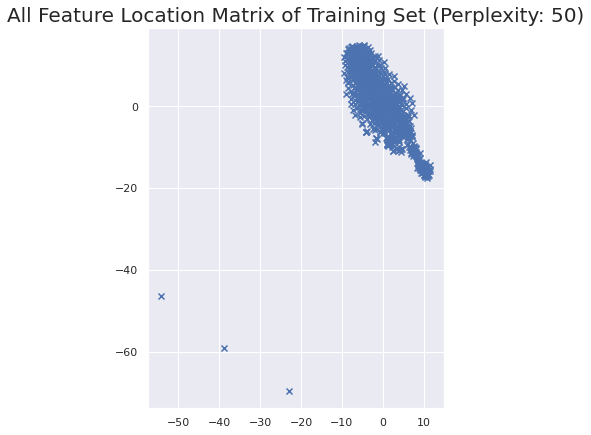

In [22]:
train_all_tsne = tsne_transform(train_all_features, perplexity=50)

In [23]:
del train_all_tsne
gc.collect()

6887

It seems clear that _"the larger the perplexity, the greater the level of feature overlaps"_. To make the features separated to some extent while still keeping their neighboring relationships, **perplexity=5** is chosen for the deepinsight transformation process.

## Convex Hull Algorithm

The convex hull algorithm is applied to find the minimum box covering all features. The rotation will be applied by considering the gradient of two of the corner coordinates of the box.

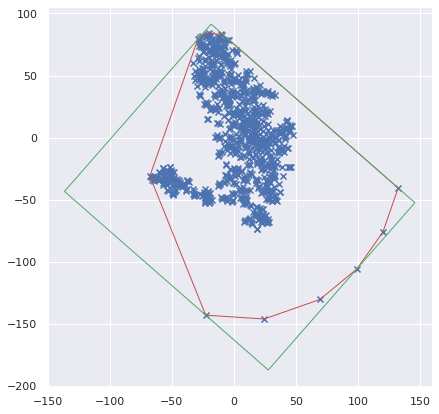

In [24]:
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=100,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=True)

In [25]:
del all_it
gc.collect()

2556

## Visualization of Feature Map

Feature maps under different resolutions are visualized. Lower resolution will cause more features to be gathered into the same pixel location.

In [26]:
# Plot image matrix with feature counts per pixel
def plot_feature_density(it, pixels=100, show_grid=True, title=None):
    # Update image size
    it.pixels = pixels

    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)

    if show_grid:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0.01,
                    linecolor="lightgrey",
                    square=False,
                    ax=ax[0, 0])
        for _, spine in ax[0, 0].spines.items():
            spine.set_visible(True)
    else:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0,
                    square=False,
                    ax=ax[0, 0])

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()

    # Feature Overlapping Counts
    gene_overlap = (
        pd.DataFrame(all_it._coords.T).assign(count=1).groupby(
            [0, 1],  # (x1, y1)
            as_index=False).count())
    print(gene_overlap["count"].describe())
    print(gene_overlap["count"].hist())
    plt.suptitle("Feauture Overlap Counts")

### Resolution: 50 x 50

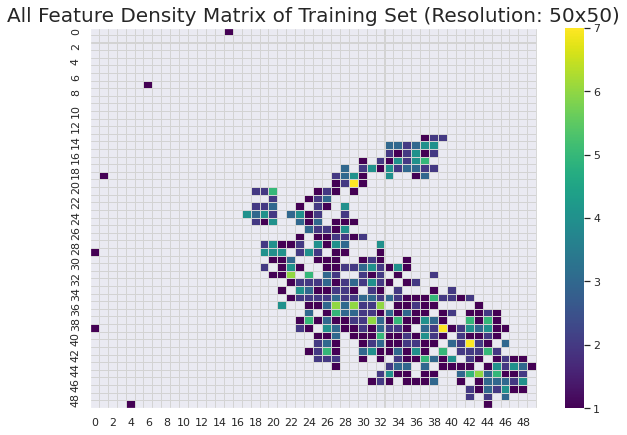

count    404.000000
mean       2.165842
std        1.314066
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: count, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


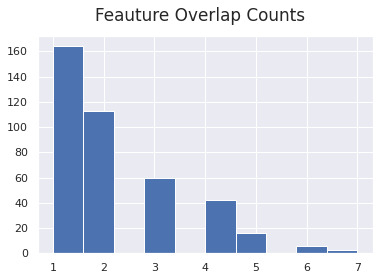

In [27]:
resolution = 50
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=resolution,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=False)
plot_feature_density(
    all_it,
    pixels=resolution,
    title=
    f"All Feature Density Matrix of Training Set (Resolution: {resolution}x{resolution})"
)

### Resolution: 100 x 100

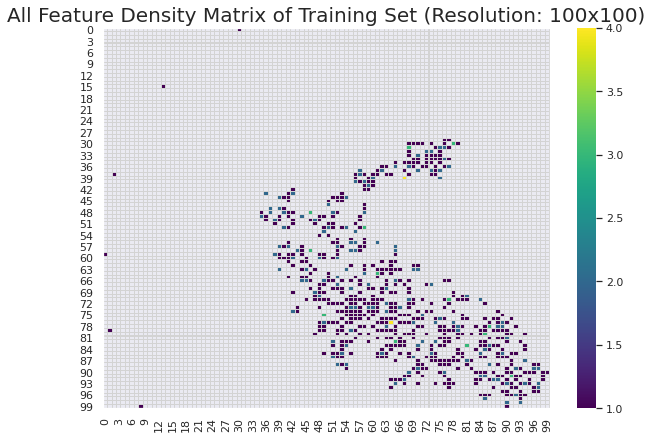

count    706.000000
mean       1.239377
std        0.486040
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: count, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


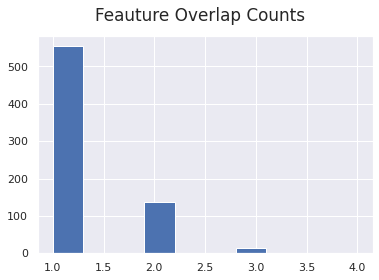

In [28]:
resolution = 100
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=resolution,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=False)
plot_feature_density(
    all_it,
    pixels=resolution,
    title=
    f"All Feature Density Matrix of Training Set (Resolution: {resolution}x{resolution})"
)

In [29]:
del all_it
gc.collect()

18666

## Visualization of Feature Images

Once we got the feature map, the raw feature values can be mapped to the corresponding pixel locations in the image. For the ease of visualization here, the resolution is set to 50.

To see if the feature images could give a good representation of the raw features in different MoA targets, we select the **top-6 most frequent classes** in the dataset and visualize a sample image for each of them.

In [30]:
resolution = 50
top_k_classes = 6

In [31]:
all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=resolution,
                                perplexity=5,
                                random_state=rand_seed,
                                n_jobs=-1)
all_it.fit(train_all_features, plot=False)

In [32]:
train_all_images = all_it.transform(train_all_features, empty_value=0)
len(train_all_images), train_all_images[0].shape

(21432, (50, 50))

In [33]:
class_counts = train_labels[train_classes].sum().to_frame(
    name="count").reset_index().rename(columns={"index": "class"})
class_counts = class_counts.sort_values(by="count",
                                        ascending=False).reset_index(drop=True)
class_counts

,class,count
0,nfkb_inhibitor,832
1,proteasome_inhibitor,726
2,cyclooxygenase_inhibitor,435
3,dopamine_receptor_antagonist,424
4,serotonin_receptor_antagonist,404
...,...,...
201,elastase_inhibitor,6
202,steroid,6
203,atm_kinase_inhibitor,6
204,erbb2_inhibitor,1


In [34]:
# Plot image matrix with feature counts per pixel
def plot_feature_images(it, labels, images, classes, title=None, n_cols=2):
    # Create subplots
    fig, ax = plt.subplots(top_k_classes // n_cols, n_cols, figsize=(12, 12))

    for i in range(0, top_k_classes // n_cols):
        for j in range(n_cols):
            class_rows = labels[labels[classes[i + j]] > 0]
            # Select the random row of each class
            sample_index = np.random.choice(class_rows.index.values, size=1)[0]
            cax = sns.heatmap(
                images[sample_index],
                # cmap='hot',
                cmap='jet',
                linewidth=0.01,
                linecolor='dimgrey',
                square=False,
                ax=ax[i, j],
                cbar=True)
            cax.axis('off')

            ax[i, j].set_title(f"{classes[i*n_cols + j]} (index: {sample_index})",
                               fontsize=14)

    plt.rcParams.update({'font.size': 14})
    if title is not None:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

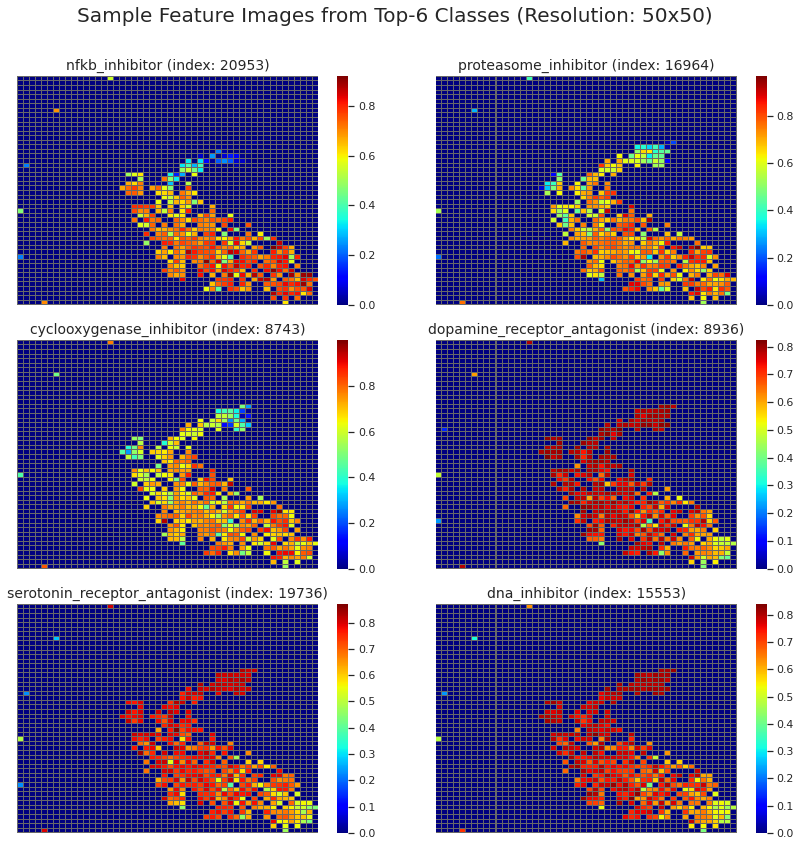

In [35]:
sample_labels = train_labels.iloc[train_index, :].copy().reset_index(drop=True)
sample_labels = sample_labels[
    class_counts["class"].values[:top_k_classes].tolist()]
sample_labels = sample_labels[sample_labels.sum(axis=1) > 0]
plot_feature_images(
    all_it,
    sample_labels,
    train_all_images,
    classes=sample_labels.columns.tolist(),
    title=
    f"Sample Feature Images from Top-{top_k_classes} Classes (Resolution: {resolution}x{resolution})"
)

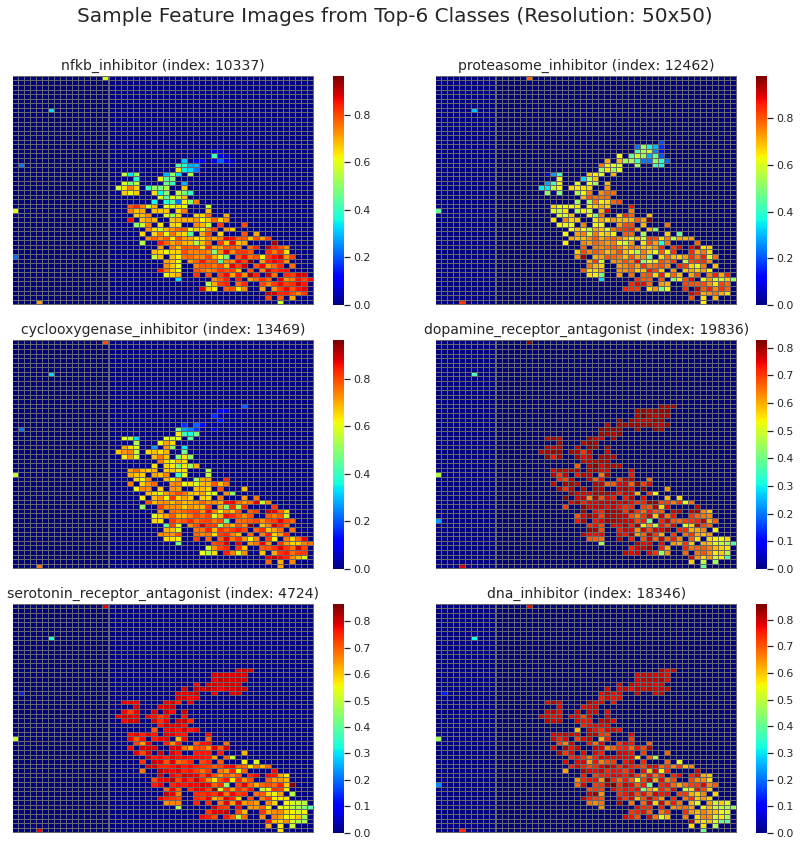

In [36]:
sample_labels = train_labels.iloc[train_index, :].copy().reset_index(drop=True)
sample_labels = sample_labels[
    class_counts["class"].values[:top_k_classes].tolist()]
sample_labels = sample_labels[sample_labels.sum(axis=1) > 0]
plot_feature_images(
    all_it,
    sample_labels,
    train_all_images,
    classes=sample_labels.columns.tolist(),
    title=
    f"Sample Feature Images from Top-{top_k_classes} Classes (Resolution: {resolution}x{resolution})"
)

Let's compare more samples of the same classes. Here we randomly select four samples from the top-1 and top-5 class.

In [37]:
top_classes = class_counts["class"].values[:top_k_classes].tolist()

In [38]:
# Plot image matrix with feature counts per pixel
def plot_class_feature_images(it,
                              labels,
                              images,
                              target_class,
                              title=None,
                              n_rows=2,
                              n_cols=2):
    # Create subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 12))

    for i in range(n_rows):
        for j in range(n_cols):
            class_rows = labels[labels[target_class] > 0]
            # Select the random row of given class
            sample_index = np.random.choice(class_rows.index.values, size=1)[0]
            cax = sns.heatmap(
                images[sample_index],
                # cmap='hot',
                cmap='jet',
                linewidth=0.01,
                linecolor='dimgrey',
                square=False,
                ax=ax[i, j],
                cbar=True)
            cax.axis('off')

            ax[i, j].set_title(f"Index: {sample_index}", fontsize=14)

    plt.rcParams.update({'font.size': 14})
    if title is not None:
        plt.suptitle(title, fontsize=24)

    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

### nfkb_inhibitor

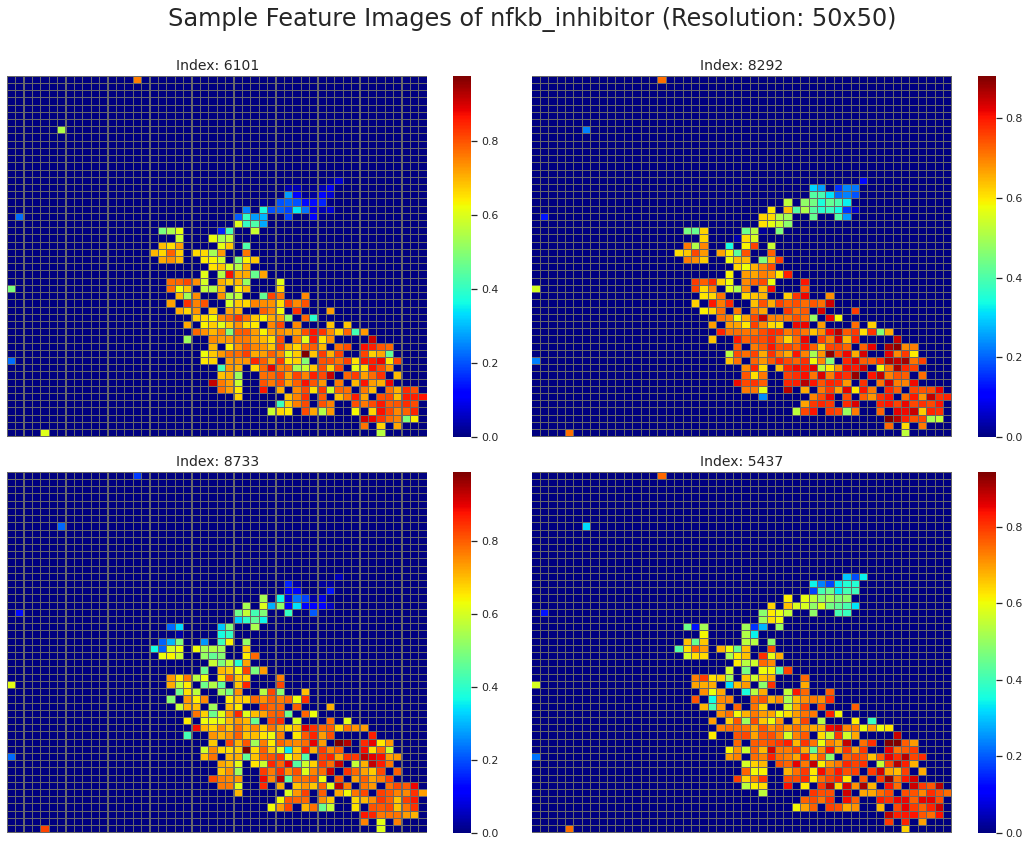

In [39]:
class_index = 0
plot_class_feature_images(
    all_it,
    sample_labels,
    train_all_images,
    target_class=top_classes[class_index],
    title=
    f"Sample Feature Images of {top_classes[class_index]} (Resolution: {resolution}x{resolution})"
)

### dna_inhibitor

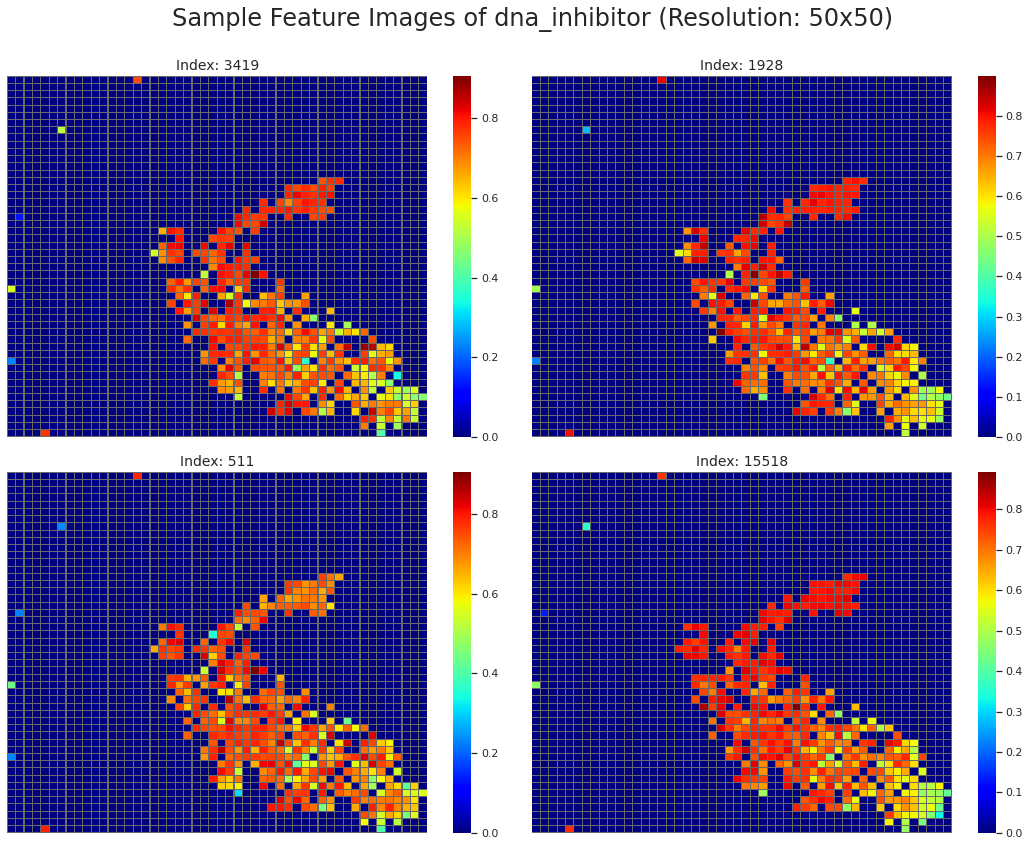

In [40]:
class_index = 5
plot_class_feature_images(
    all_it,
    sample_labels,
    train_all_images,
    target_class=top_classes[class_index],
    title=
    f"Sample Feature Images of {top_classes[class_index]} (Resolution: {resolution}x{resolution})"
)

In the two runs of views to the feature map images, we can clearly see distinguishable patterns across different MoA target classes. This is a good news to the potentials of applying CNN-based models in this competition!

# EOF
Thanks for reading through this post, I hope you gain some good ideas for the improvement and diversity of your models.